# Clustering

When you reach a certain length of text to summarize, the other methods become too expensive or are not able to summarize well enough. We need to find a way to extract all the important parts of large texts like books or very big documents, and create a summary from them.

Some simple ways to avoid using all the chunks for summarization is either randomly selecting chunks, or spacing out which chunks are selected. But what if we miss out on an important part of the text while doing this?

A solution is K-means clustering, where each chunk is embedded, and then clusters are formed based on semantic meaning of those chunks. Then a summary is formed from each cluster, hopefully netting us a more accurate summary of huge texts.

Another advantage is the amount of requests sent to the API. While Map Reduction sends many requests, clustering will send only one request, saving a lot of money.

In [1]:
from dotenv import load_dotenv
from utils import read_files, split_document_by_tokens
from pathlib import Path

import os

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
documents = read_files(Path('./content/books'))
doc = documents[0]

Set up our LLM

In [24]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-3.5-turbo-0125")

We check how many tokens are in our book. Dracula, the book we will summarize, has 216728 tokens. Yikes!

Using map reduction or stuffing on this text would cause a lot of tokens to be sent to the LLM, hurting our wallet.

In [3]:
num_tokens = llm.get_num_tokens(doc.page_content)
print(f'Our text has {num_tokens} tokens')

Our text has 216728 tokens


So, we need to start with splitting our book into chunks. To do this I will split by tokens.

In [6]:
split_docs = split_document_by_tokens([doc], chunk_size=2000, overlap=200)
print(f'Now our book is split up into {len(split_docs)} documents')

Now our book is split up into 129 documents


### Embedding

Clustering relies on embeddings to work. Embeddings are vector representations of text, so that LLMs can work with them (LLMs don't understand human readable text, they understand numbers).
Therefore we need to create embeddings from our documents.

In [8]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY, model='text-embedding-3-small')

vectors = embeddings.embed_documents([doc.page_content for doc in split_docs])

### Clustering

There are many different clustering algorithms to choose from. Let's try a few of them. We'll start with KMeans clustering.

In [12]:
from sklearn.cluster import KMeans

num_clusters = 11

kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [13]:
kmeans.labels_

array([10, 10, 10, 10, 10, 10,  2,  2,  8, 10, 10, 10, 10, 10, 10, 10, 10,
        4,  4,  6,  4,  7,  4,  8,  4,  9,  9,  9,  9,  4,  5,  4,  4,  1,
        4,  4,  4,  1,  1,  1,  5,  5,  5,  5,  5,  7,  2,  0,  0,  5,  5,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  1,  1,  7,  7,  7,  7,
        7,  7,  7,  7,  5,  1,  1,  1,  1,  1,  6,  3,  3,  1,  7,  0,  7,
        1,  6,  8,  2,  2,  8,  8,  0,  0,  0,  0,  6,  0,  0,  0,  3,  7,
        0,  0,  6,  6,  1,  9,  3,  1,  1,  5,  1,  9,  1,  6,  1,  9,  1,
        9,  3,  9,  9,  3,  3,  3,  3,  3,  3])

Time to visualize

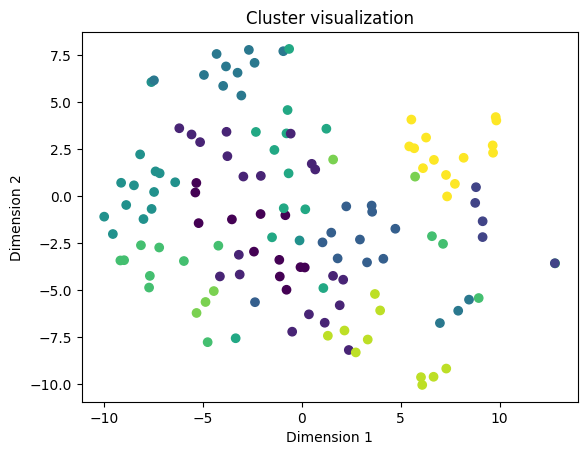

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
vectors = np.array(vectors)
reduced_data_tsne = tsne.fit_transform(vectors)

plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Cluster visualization')
plt.show()

Get the vectors which are closest to the center of the cluster

In [16]:
closest_indices = []

for i in range(num_clusters):
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    closest_index = np.argmin(distances)
    closest_indices.append(closest_index)

Then sort them so that they are processed in order

In [20]:
selected_indices = sorted(closest_indices)

list

In [21]:
selected_docs = [split_docs[doc] for doc in selected_indices]
selected_docs

[Document(page_content=' \nThis led to much conversation, and as it was evident that he wanted to talk, \nif only for talking\'s sake, I asked him ma ny questions regardin g things that had \nalready happened to me or come within my notice. Sometimes he sheered off \nthe subject, or turned the conversation  by pretending not to understand, but \ngenerally he answered all I asked most frankly. Then as time went on, and I \nhad got somewhat bolder, I asked him of  some of the strange things of the \npreceding night, as for inst ance, why the coachman we nt to the places where he \nhad seen the blue flames. He then explained to me that it was commonly \nbelieved that on a certain night of the ye ar, last night, in fact, when all evil \nspirits are supposed to have unchecked  sway, a blue flame is seen over any \nplace where treasure has been concealed.  \n"That treasure has been hidden," he went on, "in the region through which \nyou came last night, there can be but litt le doubt. For it

In [19]:
from langchain import PromptTemplate

map_prompt = """
You will be given a piece of a larger text. This piece of text will be enclosed in triple backticks (```).
Your job is to give a summary of this piece of text so that the reader will have a full understanding of what the text is about.
Your response should be at least three paragraphs and fully encompass what was written in the piece of text.

```{text}```
FULL SUMMARY:
"""

map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [25]:
from langchain.chains.summarize import load_summarize_chain

map_chain = load_summarize_chain(llm=llm, chain_type="stuff", prompt=map_prompt_template)

summary_list = []

for i, doc in enumerate(selected_docs):
    chunk_summary = map_chain.run([doc])
    summary_list.append(chunk_summary)

    print(f'Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n')

Summary #0 (chunk #7) - Preview: The piece of text describes a conversation between the narrator and Count Dracula, where the Count explains the folklore surrounding blue flames that appear over buried treasure on certain nights. He also reveals his plans to move to an old estate ca 

Summary #1 (chunk #16) - Preview: In this piece of text, the narrator finds himself in an old ruined chapel that had been used as a graveyard, where he discovers the Count lying in a wooden box, seemingly dead or asleep. The narrator is filled with dread and fear as he examines the C 

Summary #2 (chunk #24) - Preview: The piece of text provided includes two separate sections. The first part of the text is a narrative of a man contemplating the idea of furthering scientific knowledge by experimenting with the brain. He reflects on the potential advancements that co 

Summary #3 (chunk #53) - Preview: The enclosed piece of text consists of two letters and an entry from Dr. Seward's diary. The first letter 

In [26]:
llm4 = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-4-turbo-preview")

In [27]:
from langchain.schema import Document
summaries = "\n".join(summary_list)

summaries = Document(page_content=summaries)

print(f'All your summaries together are {llm.get_num_tokens(summaries.page_content)} tokens')

All your summaries together are 3235 tokens


In [29]:
combine_prompt = """
You will now be given a series of summaries from a larger text. The summaries will be enclosed in triple backticks(```).
Your goal is to give a summary of what happened in the greater piece of text.
The reader should be able to grasp what the full text is about from your summary.

```{text}```
SUMMARY:
"""

combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [30]:
reduce_chain = load_summarize_chain(llm=llm4, chain_type="stuff", prompt=combine_prompt_template)

output = reduce_chain.run([summaries])

In [31]:
print(output)

The larger piece of text encapsulates the complex and suspenseful narrative of Bram Stoker's "Dracula," weaving together various characters' perspectives and experiences as they grapple with the terrifying reality of Count Dracula's vampirism and his sinister plans. Initially introduced through a conversation between the narrator and Count Dracula, the story unfolds with the Count's relocation to England, utilizing an estate called Carfax as his base, which sets the stage for the ensuing horror. The narrative further develops with the discovery of Dracula's true nature, the mysterious illness afflicting Lucy Westenra, and the growing concern among the characters for their loved ones' safety, particularly Mina Harker.

As the story progresses, Dr. Van Helsing emerges as a central figure, leading the charge against Dracula with his deep knowledge of the supernatural. The group, including Jonathan Harker, Dr. Seward, and others, unite in their efforts to confront and ultimately defeat Dra